# New collaborations impact author's research direction

### Brief overview


### Imports & Global Variables

In [8]:
import sys
import os

sys.path.insert(0, os.path.abspath(".."))

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from box import Box
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

from util.postgres import create_sqlalchemy_connection, query

In [2]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
pg_connection = create_sqlalchemy_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)
# Set numpy random seed
np.random.seed(config.RANDOM_SEED)

n_authors = 1000
n_min_articles = 15
n_top_articles = 5

In [3]:
sql_query = f"""
WITH authors AS (SELECT DISTINCT author_id
                 FROM fct_collaboration
                 GROUP BY author_id
                 HAVING COUNT(DISTINCT article_id) > {n_min_articles}
                 ORDER BY author_id
                 LIMIT {n_authors}),
     articles AS (SELECT DISTINCT c.author_id,
                                  c.article_id,
                                  c.article_publication_dt,
                                  CASE
                                      WHEN c.has_new_author_collaboration THEN 'new'
                                      ELSE 'existing' END AS collaboration_type
                  FROM fct_collaboration c
                           INNER JOIN authors a
                                      ON c.author_id = a.author_id
                  WHERE c.is_single_author_collaboration = FALSE
                    AND c.article_id IN (SELECT article_id
                                         FROM article_text_embedding))
SELECT author_id,
       article_id,
       article_publication_dt,
       collaboration_type
FROM articles
ORDER BY author_id, article_publication_dt
"""

df = query(conn=pg_connection, query_str=sql_query)

In [4]:
sql_query = f"""
WITH authors AS (SELECT DISTINCT author_id
                 FROM fct_collaboration
                 GROUP BY author_id
                 HAVING COUNT(DISTINCT article_id) > {n_min_articles}
                 ORDER BY author_id
                 LIMIT {n_authors}),
     articles AS (SELECT DISTINCT c.article_id
                  FROM fct_collaboration c
                           INNER JOIN authors a
                                      ON c.author_id = a.author_id
                  WHERE c.is_single_author_collaboration = FALSE
                    AND c.article_id IN (SELECT article_id
                                         FROM article_text_embedding))
SELECT t.article_id,
       t.article_text_embedding
FROM article_text_embedding t
INNER JOIN articles a USING (article_id)
ORDER BY t.article_id
"""

df_embedding = query(conn=pg_connection, query_str=sql_query)

In [51]:

results = dict(
    similarities=[],
    closest_articles=[]
)

for author_id in tqdm(df['author_id'].unique()):
    # Get the author's articles and sort them by publication date
    df_author_articles = (df[df['author_id'] == author_id]
                          .sort_values("article_publication_dt")
                          .reset_index(drop=True))

    # Article embeddings of the author's articles indexed same as df_author_articles
    df_author_article_embeddings = (
        df_embedding[df_embedding['article_id'].isin(df_author_articles['article_id'])]
        .set_index("article_id")
        .reindex(df_author_articles["article_id"])
        .reset_index()
    )

    # Vertical stack of article embeddings
    author_article_embeddings = np.vstack(df_author_article_embeddings["article_text_embedding"].values)

    # Using cosine distance to calculate the distance matrix for all author's articles
    S = cosine_similarity(author_article_embeddings)

    # Iterate over the author's articles
    for idx, row in df_author_articles.iterrows():
        # Get the current article's information
        article_id = row['article_id']
        collaboration_type = row['collaboration_type']
        article_publication_dt = row['article_publication_dt']

        # Find current article's index in the author's article dataframe
        current_index = df_author_articles.index[df_author_articles["article_id"] == article_id][0]
        # Create before/after masks
        before_mask = df_author_articles["article_publication_dt"] < article_publication_dt
        after_mask = df_author_articles["article_publication_dt"] > article_publication_dt
        # Fetch indices of the articles before and after the current article
        before_indices = np.where(before_mask)[0]
        after_indices = np.where(after_mask)[0]

        # If there are not enough articles before or after the current article, skip
        if len(before_indices) < n_top_articles or len(after_indices) < n_top_articles:
            continue

        # Calculate top n most similar articles before the current article
        similarities_before = S[current_index, before_indices]
        idx_top_n_before_in_similarities_before = np.argsort(similarities_before)[::-1][:n_top_articles]

        # Calculate top n most similar articles after the current article
        similarities_after = S[current_index, after_indices]
        idx_top_n_after_in_similarities_after = np.argsort(similarities_after)[::-1][:n_top_articles]

        # Get the embeddings of the top n most similar articles before and after
        embeddings_before = author_article_embeddings[idx_top_n_before_in_similarities_before]
        embeddings_after = author_article_embeddings[idx_top_n_after_in_similarities_after]

        # Calculate the cosine similarity between the current article and the top n most similar articles before and after
        S_top = cosine_similarity(embeddings_before, embeddings_after)

        # Cross-compare the top n most similar articles before and after the current article
        for idy in range(n_top_articles):
            results['similarities'].extend(
                [
                    dict(
                        article_id=article_id,
                        article_publication_dt=article_publication_dt,
                        similarity=S_top[idy][idz],
                        collaboration_type=collaboration_type
                    ) for idz in range(n_top_articles)
                ]
            )

            results['closest_articles'].append(
                dict(
                    article_id=article_id,
                    similar_article_id=df_author_articles.loc[
                        idx_top_n_before_in_similarities_before[idy], "article_id"],
                    article_embedding=author_article_embeddings[current_index],
                    similar_article_embedding=author_article_embeddings[idx_top_n_before_in_similarities_before[idy]],
                    collaboration_type=collaboration_type,
                    timeline='before'
                )
            )

            results['closest_articles'].append(
                dict(
                    article_id=article_id,
                    similar_article_id=df_author_articles.loc[
                        idx_top_n_after_in_similarities_after[idy], "article_id"],
                    article_embedding=author_article_embeddings[current_index],
                    similar_article_embedding=author_article_embeddings[idx_top_n_after_in_similarities_after[idy]],
                    collaboration_type=collaboration_type,
                    timeline='after'
                )
            )


100%|██████████| 998/998 [01:06<00:00, 15.02it/s]


existing median: 0.88
new median: 0.89


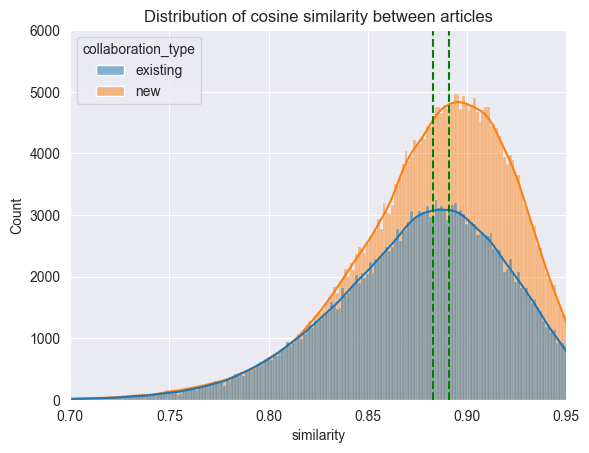

In [39]:
df_similarities = pd.DataFrame(results['similarities'])

sns.histplot(data=df_similarities, x='similarity', hue='collaboration_type', kde=True)
# Add medians
medians = df_similarities.groupby('collaboration_type')['similarity'].median()
for i, median in medians.items():
    print(f'{i} median: {median:.2f}')
    plt.axvline(median, color='g', linestyle='--', label=f'{i} median')
plt.title("Distribution of cosine similarity between articles")
plt.ylim(0, 6000)
plt.xlim(0.7, 0.95)
plt.show()

In [54]:
df_closest_articles = pd.DataFrame(results['closest_articles'])
df_closest_articles['timeline_label'] = df_closest_articles['timeline'].map({'before': 0, 'after': 1})
df_closest_articles.head(5)

,article_id,similar_article_id,article_embedding,similar_article_embedding,collaboration_type,timeline,timeline_label
0,2-s2.0-84864483652,2-s2.0-84860423756,"[0.02254791185259819, 0.059315506368875504, -0...","[0.03704354912042618, 0.06055133417248726, -0....",existing,before,0
1,2-s2.0-84864483652,2-s2.0-77957787149,"[0.02254791185259819, 0.059315506368875504, -0...","[0.07858415693044662, 0.08733870834112167, -0....",existing,after,1
2,2-s2.0-84864483652,2-s2.0-70350514742,"[0.02254791185259819, 0.059315506368875504, -0...","[0.028228508308529854, 0.0690259039402008, -0....",existing,before,0
3,2-s2.0-84864483652,10.1016/S0140-6736(14)60834-5,"[0.02254791185259819, 0.059315506368875504, -0...","[-0.0024965740740299225, 0.059058476239442825,...",existing,after,1
4,2-s2.0-84864483652,2-s2.0-58149092669,"[0.02254791185259819, 0.059315506368875504, -0...","[0.03938606008887291, 0.0580519400537014, -0.0...",existing,before,0


In [59]:
n_before = df_closest_articles[df_closest_articles['timeline'] == 'before']
n_after = df_closest_articles[df_closest_articles['timeline'] == 'after']
n_samples = min(len(n_before), len(n_after))

In [60]:
from sklearn.model_selection import train_test_split

X = list()
y = list()
ix_before = 0
ix_after = 0
for i in tqdm(range(len(df_closest_articles))):
    if df_closest_articles.loc[i, 'timeline'] == 'before' and ix_before >= n_samples:
        continue
    if df_closest_articles.loc[i, 'timeline'] == 'after' and ix_after >= n_samples:
        continue

    sim_emb = df_closest_articles.loc[i, 'similar_article_embedding']
    art_emb = df_closest_articles.loc[i, 'article_embedding']
    # Convert to list (in case they're NumPy arrays), then concatenate
    combined_emb = list(sim_emb) + list(art_emb)
    X.append(combined_emb)
    y.append(df_closest_articles.loc[i, 'timeline_label'])

X = np.array(X)  # shape will be (num_samples, dim_sim + dim_art)

# ------------------------
# 2. Train/Test Split (80/20)
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

100%|██████████| 242200/242200 [01:42<00:00, 2351.49it/s]


In [63]:
from sklearn.metrics import accuracy_score, recall_score
from xgboost import XGBClassifier

model = XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall:   {recall:.4f}")

C:\Development\eutopia-collaboration-recommender\ecr-analytics\virtualenv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:58:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6671
Recall:   0.6194
